In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Importing the databases that we need


In [228]:
# loading in statistics for college players
college_stats = pd.read_csv('all_college_data.csv')

# removing college players that were not drafted and don't have advanced stats
college_stats = college_stats[college_stats['Pick'].notna()]
college_stats = college_stats.dropna(subset = ['PER'])

# dropping all the coloumns that are not going to be used in estimation
cols = ['Player', 'Pick', 'GP', 'MPG', 'PER', 'ORB', 'DRB', 'APG', 'BPG', 'SPG', 'FTM', 'FT%', '3PM', '3P%', 'TS%', 'TOV', 'eFG%', 'ORtg', 'DRtg']
college_stats = college_stats[cols]

# loading in career stats for NBA
nba_stats = pd.read_csv('draft-data-20-years.csv')

# removing all columns except win share which is our target
nba_stats = nba_stats[['Player', 'WS']]

# joining college stats on player Name to add target of WS
data = college_stats.set_index('Player').join(nba_stats.set_index('Player'))
data.reset_index(inplace=True)


# making sure we have a WS for every player in our data set, remove those who don't 
data = data[data['WS'].notna()]

data

,Player,Pick,GP,MPG,PER,ORB,DRB,APG,BPG,SPG,FTM,FT%,3PM,3P%,TS%,TOV,eFG%,ORtg,DRtg,WS
0,A.J. Price,52.0,35,31.8,20.4,0.6,2.9,4.7,0.0,0.7,2.7,0.721,2.3,0.402,0.551,2.7,0.508,118.2,101.1,2.2
1,Aaron Brooks,26.0,35,36.8,21.1,0.9,3.4,4.3,0.2,1.4,3.3,0.846,2.3,0.404,0.589,2.5,0.546,120.9,99.0,5.5
2,Aaron Gray,49.0,33,27.9,27.0,3.7,6.8,1.8,1.5,0.6,3.6,0.634,0.0,0.000,0.567,2.7,0.565,117.9,92.1,1.4
3,Acie Law,11.0,34,33.9,22.5,0.2,3.1,5.0,0.0,1.1,4.2,0.778,1.1,0.458,0.591,2.6,0.544,118.2,92.9,0.7
4,Adam Morrison,3.0,33,36.5,29.4,1.4,4.2,1.8,0.3,1.1,7.3,0.772,2.2,0.428,0.605,2.3,0.556,124.8,105.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,Will Blalock,60.0,30,35.8,18.7,0.8,3.1,6.1,0.1,2.2,2.0,0.659,1.6,0.398,0.525,3.0,0.506,104.6,100.4,-0.1
415,Willie Green,41.0,30,34.0,28.1,1.1,3.9,2.5,0.4,1.3,5.1,0.805,1.2,0.378,0.576,2.3,0.527,119.2,97.2,2.5
416,Willie Warren,54.0,36,31.3,18.5,0.5,1.7,3.1,0.1,1.1,3.2,0.781,1.9,0.372,0.606,2.2,0.565,119.6,103.0,0.2
417,Wilson Chandler,23.0,34,31.7,20.5,1.9,5.1,1.4,1.4,0.6,2.1,0.654,1.1,0.333,0.516,1.6,0.495,106.8,97.9,3.9


Cleaning the Data

In [255]:
# filling in means for NaN values in stats
# not many NaN values, because we are taking drafted players only(i.e. high value players, which typically have complete statistics)
# therefore mean is appropriate

# we do not do this for picks over WS cause we already filter out NaN values for them
cols = ['Player', 'Pick', 'GP', 'MPG', 'PER', 'ORB', 'DRB', 'APG', 'BPG', 'SPG', 'FTM', 'FT%', '3PM', '3P%', 'TS%', 'TOV', 'eFG%', 'ORtg', 'ORtg']
cols_to_adjust = cols[1:]

for col in cols_to_adjust:
  data[col] = data[col].fillna(data[col].mean())

data.head() # cleaned data

,Player,Pick,GP,MPG,PER,ORB,DRB,APG,BPG,SPG,FTM,FT%,3PM,3P%,TS%,TOV,eFG%,ORtg,DRtg,WS
0,A.J. Price,52.0,35,31.8,20.4,0.6,2.9,4.7,0.0,0.7,2.7,0.721,2.3,0.402,0.551,2.7,0.508,118.2,101.1,2.2
1,Aaron Brooks,26.0,35,36.8,21.1,0.9,3.4,4.3,0.2,1.4,3.3,0.846,2.3,0.404,0.589,2.5,0.546,120.9,99.0,5.5
2,Aaron Gray,49.0,33,27.9,27.0,3.7,6.8,1.8,1.5,0.6,3.6,0.634,0.0,0.000,0.567,2.7,0.565,117.9,92.1,1.4
3,Acie Law,11.0,34,33.9,22.5,0.2,3.1,5.0,0.0,1.1,4.2,0.778,1.1,0.458,0.591,2.6,0.544,118.2,92.9,0.7
4,Adam Morrison,3.0,33,36.5,29.4,1.4,4.2,1.8,0.3,1.1,7.3,0.772,2.2,0.428,0.605,2.3,0.556,124.8,105.5,0.0


Correlation Matrix

In [230]:
corr = data.corr().abs()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-230-e01d04d4f8c2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr().abs()
<ipython-input-230-e01d04d4f8c2>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Pick,GP,MPG,PER,ORB,DRB,APG,BPG,SPG,FTM,FT%,3PM,3P%,TS%,TOV,eFG%,ORtg,DRtg,WS
Pick,1.00,0.13,0.01,0.20,0.05,0.11,0.07,0.14,0.06,0.17,0.02,0.07,0.00,0.05,0.14,0.04,0.08,0.17,0.47
GP,0.13,1.00,0.17,0.06,0.07,0.10,0.05,0.04,0.04,0.26,0.10,0.02,0.03,0.04,0.24,0.07,0.11,0.30,0.06
MPG,0.01,0.17,1.00,0.06,0.24,0.05,0.47,0.29,0.37,0.44,0.41,0.44,0.22,0.05,0.47,0.23,0.05,0.31,0.01
PER,0.20,0.06,0.06,1.00,0.39,0.46,0.15,0.27,0.04,0.52,0.07,0.11,0.06,0.39,0.01,0.33,0.51,0.17,0.21
ORB,0.05,0.07,0.24,0.39,1.00,0.71,0.62,0.62,0.31,0.01,0.49,0.70,0.46,0.02,0.23,0.15,0.01,0.37,0.07
DRB,0.11,0.10,0.05,0.46,0.71,1.00,0.38,0.56,0.23,0.19,0.27,0.49,0.24,0.02,0.01,0.07,0.04,0.41,0.09
APG,0.07,0.05,0.47,0.15,0.62,0.38,1.00,0.52,0.55,0.14,0.33,0.42,0.28,0.07,0.55,0.27,0.00,0.26,0.07
BPG,0.14,0.04,0.29,0.27,0.62,0.56,0.52,1.00,0.39,0.10,0.45,0.59,0.33,0.02,0.22,0.19,0.08,0.41,0.05
SPG,0.06,0.04,0.37,0.04,0.31,0.23,0.55,0.39,1.00,0.12,0.19,0.34,0.22,0.10,0.32,0.20,0.00,0.02,0.10
FTM,0.17,0.26,0.44,0.52,0.01,0.19,0.14,0.10,0.12,1.00,0.45,0.13,0.07,0.16,0.45,0.16,0.22,0.21,0.14


Splitting the Data

In [232]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error


# we remove pick as the goal is to determine the value of a college prospect
# therefore their draft order cannot be considered although it has a high correlation
X = data.drop(['Pick','Player', 'WS'], axis = 1)
y = data['WS']

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train

,GP,MPG,PER,ORB,DRB,APG,BPG,SPG,FTM,FT%,3PM,3P%,TS%,TOV,eFG%,ORtg,DRtg
21,35,32.5,17.5,0.50,2.90,4.90,0.20,2.00,1.90,0.815,2.80,0.407,0.632,2.80,0.603,117.0,96.2
411,26,34.3,26.0,3.20,7.80,1.40,0.60,0.60,5.50,0.816,0.20,0.286,0.616,2.30,0.558,123.7,92.4
232,27,31.3,29.7,0.90,3.90,1.70,0.30,1.90,7.60,0.817,1.90,0.336,0.602,3.10,0.532,117.6,93.9
193,37,35.8,29.3,0.60,2.80,4.30,0.00,1.30,6.80,0.894,3.40,0.396,0.594,3.50,0.533,118.1,98.7
50,35,35.3,20.5,2.10,6.00,1.60,1.10,1.40,2.30,0.664,1.50,0.374,0.586,2.00,0.569,112.8,95.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,36,24.5,20.5,2.58,3.08,0.61,2.25,0.50,2.39,0.652,0.03,1.000,0.565,1.75,0.536,109.7,94.3
199,37,25.2,22.3,4.38,5.00,0.35,2.19,1.43,1.92,0.467,0.00,0.000,0.581,1.70,0.614,113.0,81.5
119,37,34.3,19.7,2.80,5.90,3.20,1.40,1.00,2.40,0.647,0.80,0.326,0.531,3.20,0.500,102.3,86.1
48,34,30.4,28.1,3.00,4.40,1.20,0.90,1.20,5.90,0.726,0.10,0.211,0.645,3.00,0.602,119.2,92.9


Preprocessing Data

In [238]:
from sklearn import preprocessing

# defining an object of MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()

# normalize values between 0 and 1 using the training data
X_train_scaled = min_max_scaler.fit_transform(X_train)

# visualizing shape of scaled data
X_train_scaled.shape

(286, 17)

Linear Regression

In [261]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate

# defining the model as an object of LinearRegression()
lin_model = linear_model.LinearRegression()

# fit the model on the scaled training data
lin_model.fit(X_train_scaled, y_train)

# calculating scores
lin_model.score(X_train_scaled, y_train)

0.13630552875816937

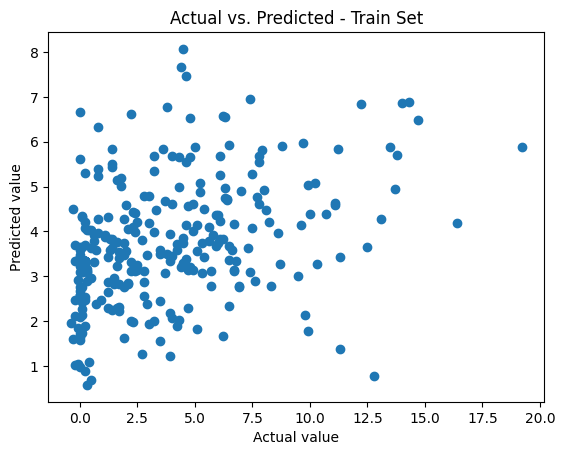

In [235]:
# calculate the predicted values for training data
y_pred_train = lin_model.predict(X_train_scaled)

# visualize the difference between actual and predicted data using scatter plot
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title("Actual vs. Predicted - Train Set")
plt.show()